In [ ]:
!pip install opencv-contrib-python-headless==4.12.0.88

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 17.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
import os
import glob
from google.colab import drive

In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = "/content/drive/MyDrive/aruco.JPG"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

 Dictionary: DICT_ARUCO_ORIGINAL
 Detected 25 marker(s)
 IDs: [292, 143, 800, 772, 815, 710, 207, 536, 707, 689, 196, 699, 407, 620, 1002, 613, 805, 800, 566, 868, 110, 415, 1009, 578, 313]


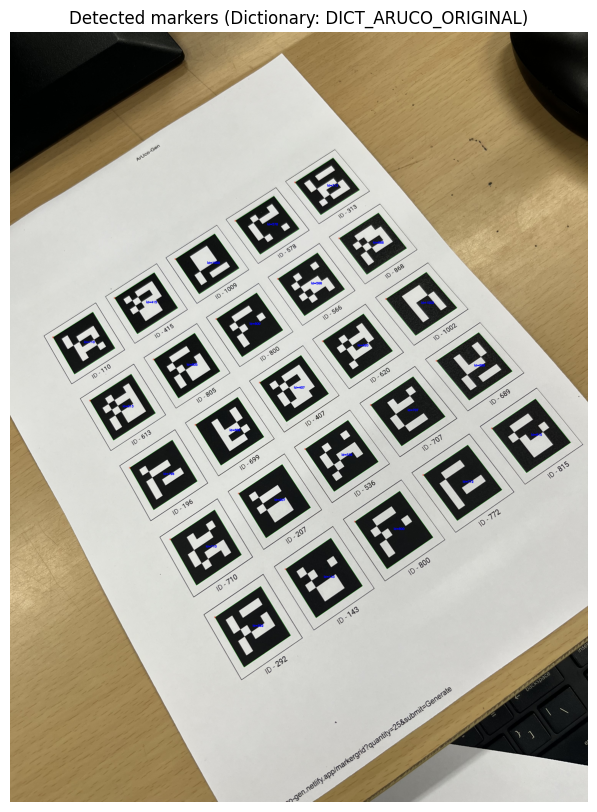

In [ ]:
aruco_dicts = {
    "DICT_4X4_50": aruco.DICT_4X4_50,
    "DICT_5X5_50": aruco.DICT_5X5_50,
    "DICT_6X6_50": aruco.DICT_6X6_50,
    "DICT_7X7_50": aruco.DICT_7X7_50,
    "DICT_ARUCO_ORIGINAL": aruco.DICT_ARUCO_ORIGINAL
}


# for each dictionary
best = None
max_detected = 0
best_corners = None
best_ids = None
best_dict = None

for name, dict_id in aruco_dicts.items():
    dictionary = aruco.getPredefinedDictionary(dict_id)
    parameters = aruco.DetectorParameters()
    corners, ids, _ = aruco.detectMarkers(gray, dictionary, parameters=parameters)

    if ids is not None and len(ids) > max_detected:
        best = name
        best_dict = dictionary
        best_corners = corners
        best_ids = ids
        max_detected = len(ids)

# Show result
if best_ids is not None:
    print(f" Dictionary: {best}")
    print(f" Detected {len(best_ids)} marker(s)")
    print(f" IDs: {best_ids.flatten().tolist()}")

    output = image.copy()
    aruco.drawDetectedMarkers(output, best_corners, best_ids)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected markers (Dictionary: {best})")
    plt.axis("off")
    plt.show()
else:
    print(" No markers detected in any dictionary.")

In [ ]:
# checkerboard info:
chessboard_size = (7, 10)  # (columns, rows of inner corners)
square_size = 0.012  # 12mm square size

image_dir = "/content/drive/MyDrive/aruco_chessboard"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

In [ ]:
# Generate 3D points for checkerboard
obj = np.zeros((np.prod(chessboard_size), 3), np.float32)
obj[:, :2] = np.indices(chessboard_size).T.reshape(-1, 2)
obj *= square_size

objpoints = []
imgpoints = []

# Loop and detect corners
for path in image_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, chessboard_size)

    if ret:
        objpoints.append(obj)
        imgpoints.append(corners)

        # Draw and show
        img_display = cv2.drawChessboardCorners(img.copy(), chessboard_size, corners, ret)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected: {os.path.basename(path)}")
        plt.axis("off")
        plt.show()
    else:
        print(f" Pattern not found in {os.path.basename(path)}")

print(f"\n Used {len(objpoints)} valid images out of {len(image_paths)}")

# Camera calibration
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

# Show calibration results
print("\n Calibration Complete!")
print("Camera Matrix:\n", camera_matrix)
print("\nDistortion Coefficients:\n", dist_coeffs)

# saving camera matrix and distortion coeffs in drive
np.savetxt("/content/drive/MyDrive/camera_matrix.csv", camera_matrix, delimiter=",")
np.savetxt("/content/drive/MyDrive/dist_coeffs.csv", dist_coeffs, delimiter=",")

Output hidden; open in https://colab.research.google.com to view.

Marker ID: 292
Rotation Vector (rvec): [ 2.7220386  -0.85126783 -0.13424819]
Translation Vector (tvec): [-0.02796356  0.10307188  0.29032212]

Marker ID: 143
Rotation Vector (rvec): [ 2.77622154 -0.86440553 -0.12801703]
Translation Vector (tvec): [0.00730321 0.08002367 0.29527413]

Marker ID: 800
Rotation Vector (rvec): [ 2.69563255 -0.81668843  0.03168764]
Translation Vector (tvec): [0.04259464 0.05623684 0.29682455]

Marker ID: 772
Rotation Vector (rvec): [ 2.68836146e+00 -8.10223256e-01  1.40089550e-03]
Translation Vector (tvec): [0.07759496 0.03260512 0.29745364]

Marker ID: 815
Rotation Vector (rvec): [ 2.69452629 -0.80230403 -0.05824611]
Translation Vector (tvec): [0.11230005 0.00881737 0.29570636]

Marker ID: 710
Rotation Vector (rvec): [ 2.72682639 -0.8354109  -0.04206265]
Translation Vector (tvec): [-0.05416552  0.06773418  0.30885909]

Marker ID: 207
Rotation Vector (rvec): [ 2.72730744 -0.83632007 -0.02960394]
Translation Vector (tvec): [-0.01843104  0.04400219  0.31259418]


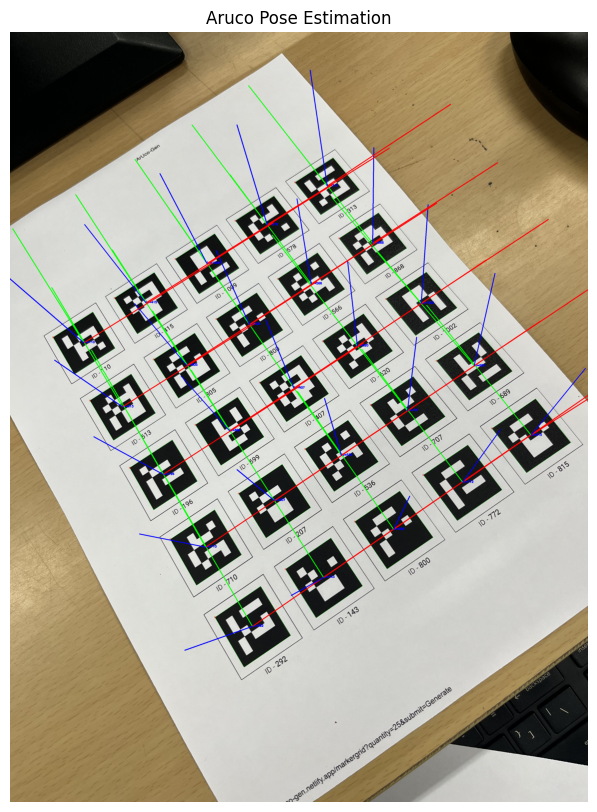

In [ ]:
# Load camera parameters
camera_matrix = np.loadtxt("/content/drive/MyDrive/camera_matrix.csv", delimiter=",")
dist_coeffs = np.loadtxt("/content/drive/MyDrive/dist_coeffs.csv", delimiter=",")

# Set ArUco dictionary and marker size
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
parameters = aruco.DetectorParameters()

marker_length = 0.028  # aruco size in meters(measured with scale)

# Load image
image_path = "/content/drive/MyDrive/aruco.JPG"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect markers
corners, ids, _ = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

if ids is not None:
    output = image.copy()
    aruco.drawDetectedMarkers(output, corners, ids)

    # Estimate pose
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(
        corners, marker_length, camera_matrix, dist_coeffs)

    for i in range(len(ids)):
        # Draw 3D axis (X-red, Y-green, Z-blue)
        cv2.drawFrameAxes(output, camera_matrix, dist_coeffs, rvecs[i], tvecs[i], 0.09)

        # Print rvec and tvec
        print(f"Marker ID: {ids[i][0]}")
        print(f"Rotation Vector (rvec): {rvecs[i].flatten()}")
        print(f"Translation Vector (tvec): {tvecs[i].flatten()}\n")


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Aruco Pose Estimation")
    plt.axis("off")
    plt.show()
else:
    print(" No markers detected.")

Marker ID: 292, Distance from camera: 0.31 meters
Marker ID: 143, Distance from camera: 0.31 meters
Marker ID: 800, Distance from camera: 0.31 meters
Marker ID: 772, Distance from camera: 0.31 meters
Marker ID: 815, Distance from camera: 0.32 meters
Marker ID: 710, Distance from camera: 0.32 meters
Marker ID: 207, Distance from camera: 0.32 meters
Marker ID: 536, Distance from camera: 0.31 meters
Marker ID: 707, Distance from camera: 0.32 meters
Marker ID: 689, Distance from camera: 0.32 meters
Marker ID: 196, Distance from camera: 0.34 meters
Marker ID: 699, Distance from camera: 0.33 meters
Marker ID: 407, Distance from camera: 0.33 meters
Marker ID: 620, Distance from camera: 0.33 meters
Marker ID: 1002, Distance from camera: 0.34 meters
Marker ID: 613, Distance from camera: 0.35 meters
Marker ID: 805, Distance from camera: 0.35 meters
Marker ID: 800, Distance from camera: 0.34 meters
Marker ID: 566, Distance from camera: 0.35 meters
Marker ID: 868, Distance from camera: 0.36 meters

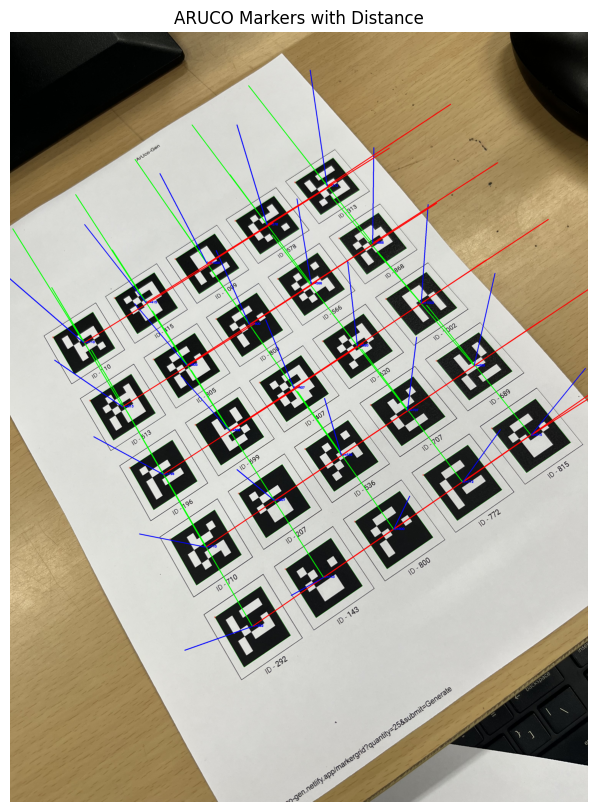

In [ ]:
# distance calculation
for i, (corner, marker_id) in enumerate(zip(corners, ids)):
    # Compute pose estimation for the current marker
    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corner, marker_length, camera_matrix, dist_coeffs)

    # Extract the translation vector (tvec) and calculate the distance
    tvec_single = tvec[0, 0]  # Get the 3D translation vector
    distance = np.linalg.norm(tvec_single)

    print(f"Marker ID: {marker_id[0]}, Distance from camera: {distance:.2f} meters")


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("ARUCO Markers with Distance")
plt.axis('off')
plt.show()